### **Statisctial Analysis on the Data**


🔍 Checking missing values before fill:
ClearSkyRadiation    2016
SolarRadiation       2016
DirectRadiation      2016
DiffuseRadiation     2016
SolarZenith          2016
Temperature            72
HumiditySpecific       72
HumidityRelative       72
Pressure               72
WindSpeed              72
WindDirection          72
dtype: int64

✅ Missing values filled using 2018–2024 climatology (Jul–Oct 2025)

📊 Basic Descriptive Statistics:
                     count        mean         std    min     25%     50%  \
ClearSkyRadiation  68448.0  231.955154  304.082804   0.00    0.00   11.12   
SolarRadiation     68448.0  200.427805  275.379165   0.00    0.00    9.52   
DirectRadiation    68448.0  158.136201  243.170856   0.00    0.00    0.00   
DiffuseRadiation   68448.0   90.976418  118.266235   0.00    0.00   11.26   
SolarZenith        68448.0   72.461867   22.730187  10.59   56.19   88.07   
Temperature        68448.0   25.099201    9.608141   0.32   17.76   26.23   
HumiditySpecific   68

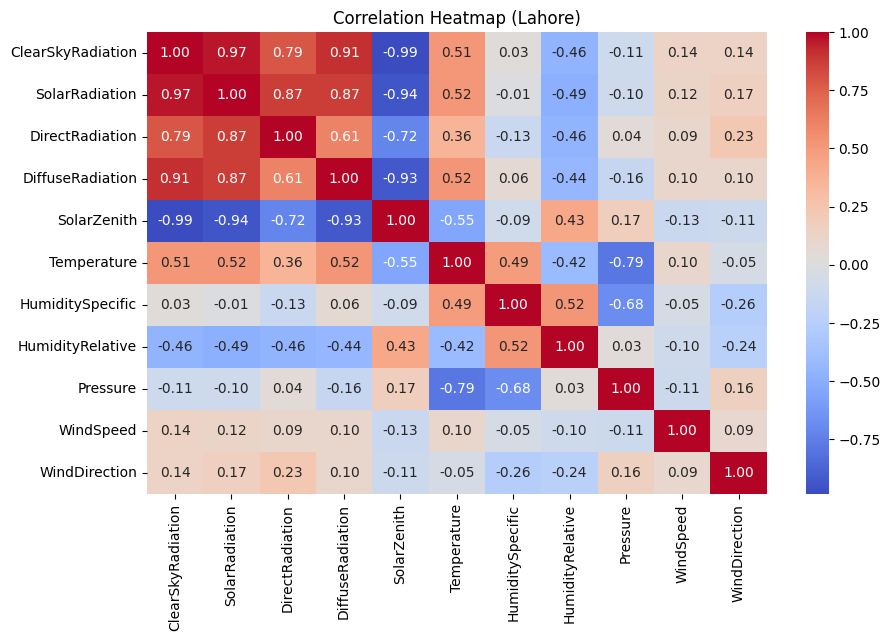

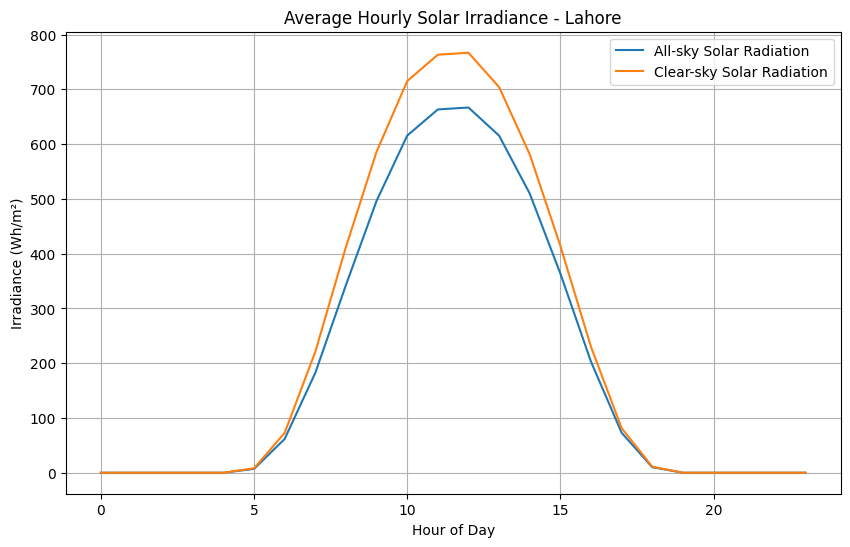

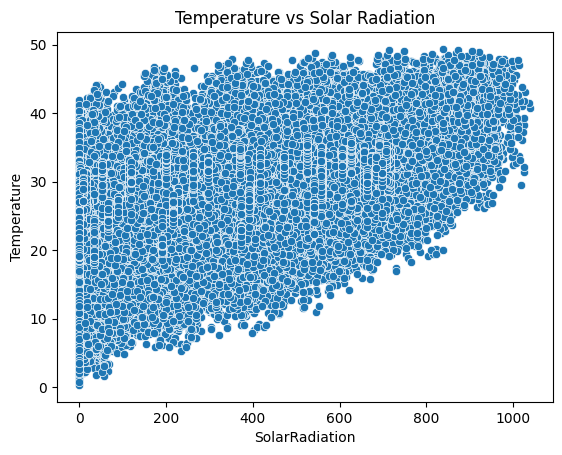

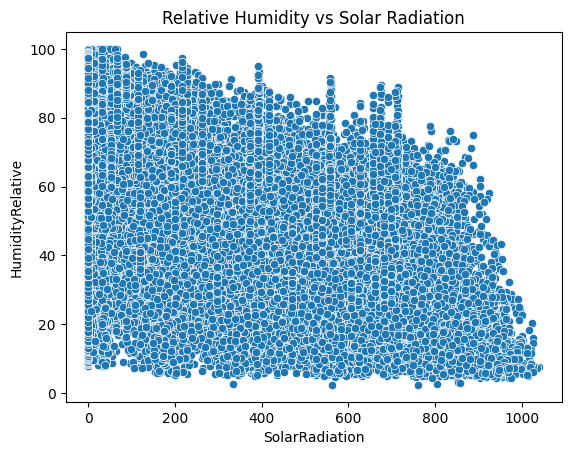

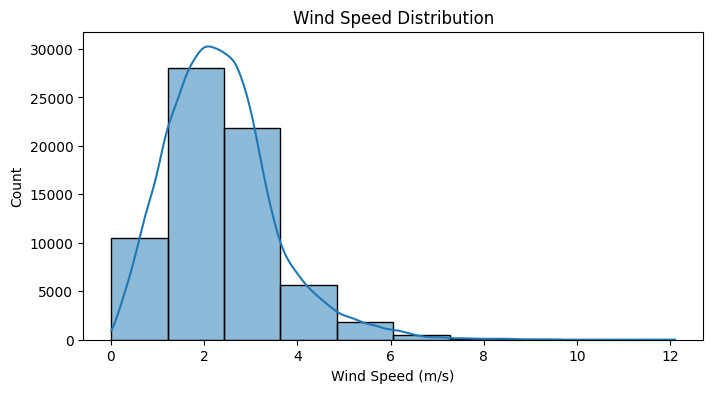

/tmp/ipython-input-4228583507.py:146: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df.resample('M').mean(numeric_only=True)


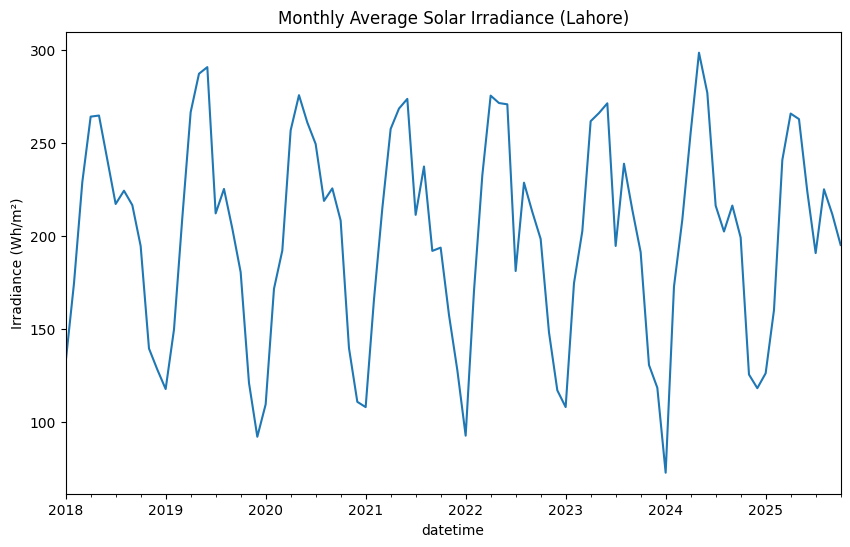


✅ Cleaned and climatology-filled dataset saved as 'lahore_hourly_filled.csv'


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================
# 1️⃣ Load and Prepare the Data
# ==========================================================

# Load data
df = pd.read_csv('NASA-Lahore-Hourly-Data.csv', sep='\t|,', engine='python')

# Replace missing placeholders
df.replace(-999, np.nan, inplace=True)

# Create datetime index
df['datetime'] = pd.to_datetime(df[['YEAR', 'MO', 'DY', 'HR']].rename(columns={
    'YEAR': 'year',
    'MO': 'month',
    'DY': 'day',
    'HR': 'hour'
}))
df.set_index('datetime', inplace=True)

# Drop redundant columns
df.drop(columns=['YEAR', 'MO', 'DY', 'HR'], inplace=True)

# ==========================================================
# 2️⃣ Rename Columns for Readability
# ==========================================================

df.rename(columns={
    'CLRSKY_SFC_SW_DWN': 'ClearSkyRadiation',
    'ALLSKY_SFC_SW_DWN': 'SolarRadiation',
    'ALLSKY_SFC_SW_DNI': 'DirectRadiation',
    'ALLSKY_SFC_SW_DIFF': 'DiffuseRadiation',
    'SZA': 'SolarZenith',
    'T2M': 'Temperature',
    'QV2M': 'HumiditySpecific',
    'RH2M': 'HumidityRelative',
    'PS': 'Pressure',
    'WS10M': 'WindSpeed',
    'WD10M': 'WindDirection'
}, inplace=True)

# ==========================================================
# 3️⃣ Handle Missing Data — Multi-Year Climatological Fill
# ==========================================================

print("\n🔍 Checking missing values before fill:")
print(df.isna().sum())

# Extract month/hour for climatology
df['month'] = df.index.month
df['hour'] = df.index.hour

# Compute climatological mean from 2018–2024 (exclude 2025)
climatology = (
    df[df.index.year < 2025]
    .groupby(['month', 'hour'])
    .mean(numeric_only=True)
)

# Identify the missing block (Jul–Oct 2025)
mask_missing = (df.index >= '2025-07-01') & (df.index < '2025-11-01')

# Apply climatology to missing months
def fill_with_climatology(row):
    if pd.isna(row).any():
        m, h = row['month'], row['hour']
        if (m, h) in climatology.index:
            for col in climatology.columns:
                if pd.isna(row[col]) and col in climatology.columns:
                    row[col] = round(climatology.loc[(m, h), col], 2)
    return row

df.loc[mask_missing] = df.loc[mask_missing].apply(fill_with_climatology, axis=1)

print("\n✅ Missing values filled using 2018–2024 climatology (Jul–Oct 2025)")

# Drop helper columns
df.drop(columns=['month', 'hour'], inplace=True)

# ==========================================================
# 4️⃣ Descriptive Statistics
# ==========================================================

print("\n📊 Basic Descriptive Statistics:")
print(df.describe().T)

# ==========================================================
# 5️⃣ Correlation Analysis
# ==========================================================

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Lahore)')
plt.show()

# ==========================================================
# 6️⃣ Hourly Averages (Diurnal Pattern)
# ==========================================================

hourly_avg = df.groupby(df.index.hour).mean(numeric_only=True)

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg['SolarRadiation'], label='All-sky Solar Radiation')
plt.plot(hourly_avg.index, hourly_avg['ClearSkyRadiation'], label='Clear-sky Solar Radiation')
plt.xlabel('Hour of Day')
plt.ylabel('Irradiance (Wh/m²)')
plt.title('Average Hourly Solar Irradiance - Lahore')
plt.legend()
plt.grid()
plt.show()

# ==========================================================
# 7️⃣ Temperature vs. Solar Radiation
# ==========================================================

sns.scatterplot(data=df, x='SolarRadiation', y='Temperature')
plt.title('Temperature vs Solar Radiation')
plt.show()

# ==========================================================
# 8️⃣ Humidity vs. Solar Radiation
# ==========================================================

sns.scatterplot(data=df, x='SolarRadiation', y='HumidityRelative')
plt.title('Relative Humidity vs Solar Radiation')
plt.show()

# ==========================================================
# 9️⃣ Wind Speed Distribution
# ==========================================================

plt.figure(figsize=(8, 4))
sns.histplot(df['WindSpeed'], bins=10, kde=True)
plt.title('Wind Speed Distribution')
plt.xlabel('Wind Speed (m/s)')
plt.show()

# ==========================================================
# 🔟 Monthly Trends
# ==========================================================

monthly_avg = df.resample('M').mean(numeric_only=True)

plt.figure(figsize=(10, 6))
monthly_avg['SolarRadiation'].plot(title='Monthly Average Solar Irradiance (Lahore)')
plt.ylabel('Irradiance (Wh/m²)')
plt.show()

# ==========================================================
# ✅ Save Cleaned Data
# ==========================================================

df.to_csv('lahore_hourly_filled.csv', index=True)
print("\n✅ Cleaned and climatology-filled dataset saved as 'lahore_hourly_filled.csv'")


**Average over all years to see typical monthly behavior. Useful to visualize seasons (summer peaks, winter lows).**

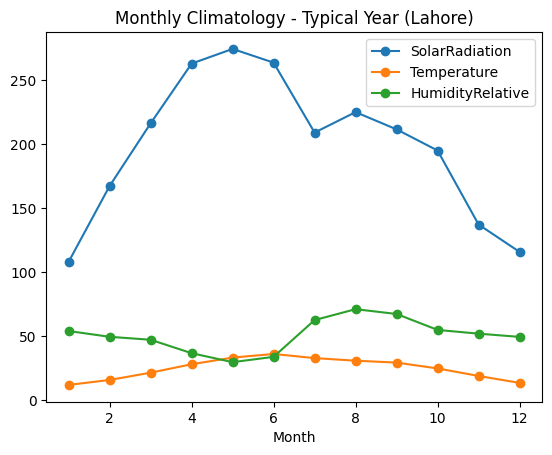

In [18]:
monthly_clim = df.groupby(df.index.month).mean(numeric_only=True)
monthly_clim[['SolarRadiation', 'Temperature', 'HumidityRelative']].plot(marker='o')
plt.title("Monthly Climatology - Typical Year (Lahore)")
plt.xlabel("Month")
plt.show()


**See how the diurnal pattern changes month to month. Reveals sunrise/sunset shift and seasonal daylight variation.**

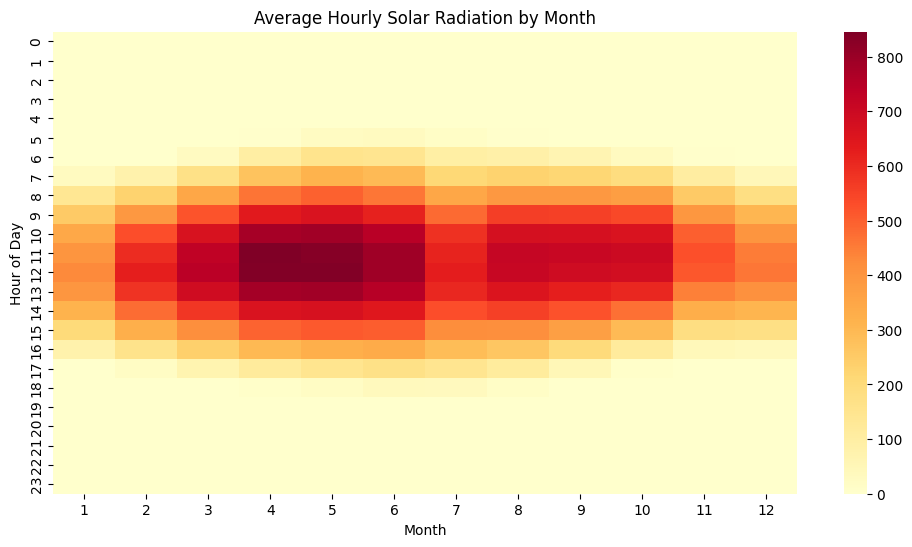

In [19]:
plt.figure(figsize=(12,6))
sns.heatmap(df.pivot_table(values='SolarRadiation',
                           index=df.index.hour,
                           columns=df.index.month,
                           aggfunc='mean'),
            cmap='YlOrRd')
plt.title('Average Hourly Solar Radiation by Month')
plt.xlabel('Month')
plt.ylabel('Hour of Day')
plt.show()


**Helps detect nonlinear relations or correlated predictors.**

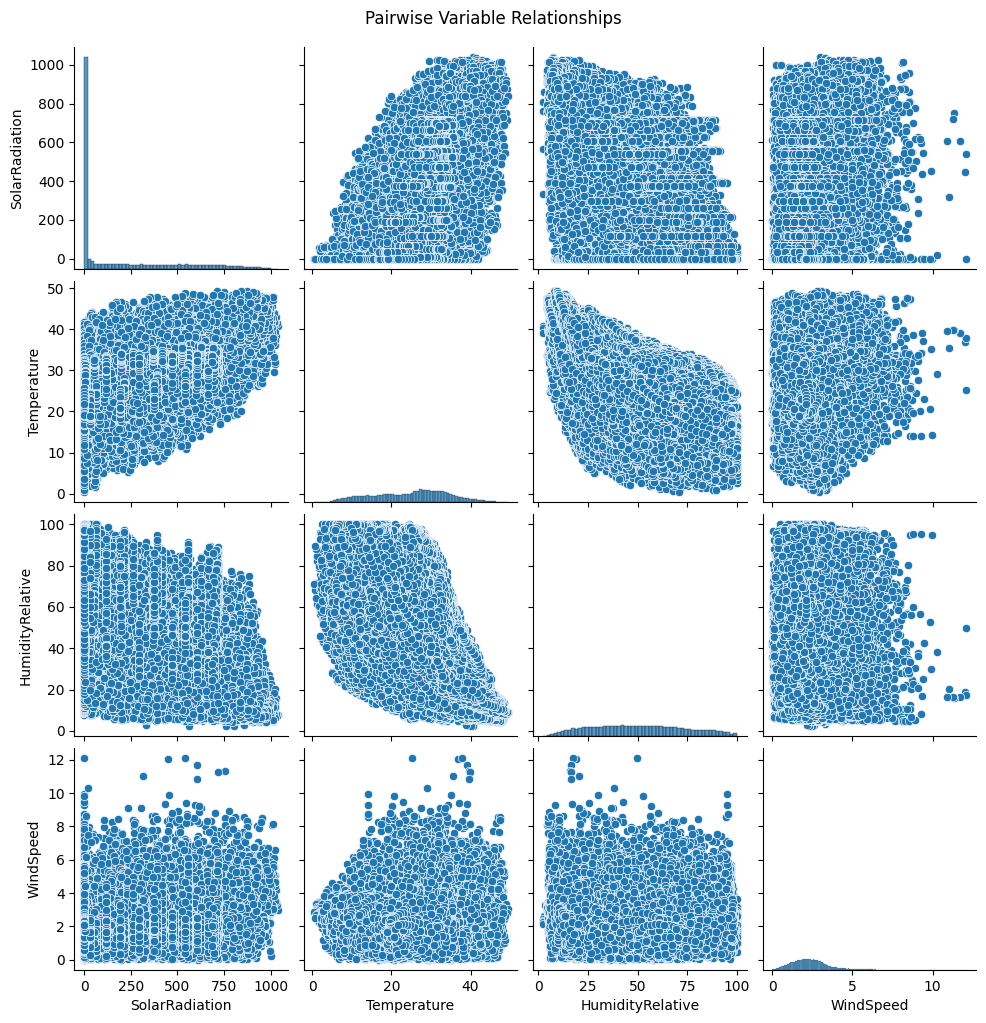

In [21]:
sns.pairplot(df[['SolarRadiation', 'Temperature', 'HumidityRelative', 'WindSpeed']])
plt.suptitle("Pairwise Variable Relationships", y=1.02)
plt.show()


**Analyze wind direction/speed distributions. Reveals dominant wind direction patterns.**

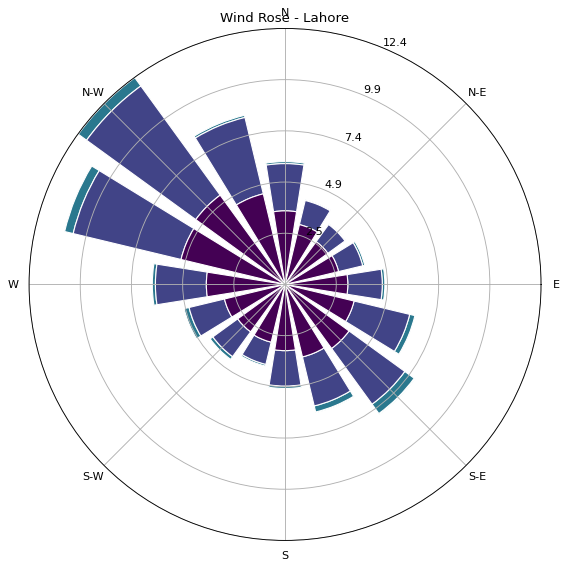

In [24]:
import windrose
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(df['WindDirection'], df['WindSpeed'], normed=True, opening=0.8, edgecolor='white')
ax.set_title("Wind Rose - Lahore")
plt.show()


**Rolling Statistics (Moving Average): Identify slow-changing trends over time. Highlights long-term smoothing and anomalies.**

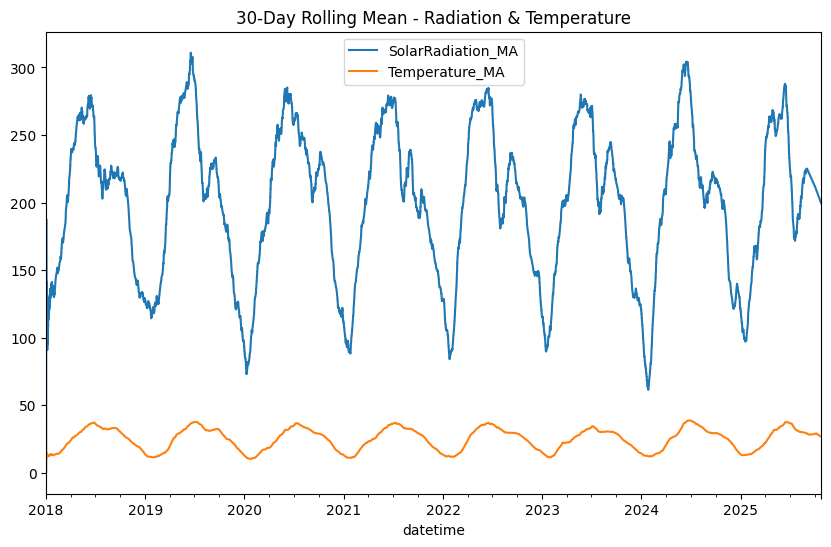

In [25]:
df['SolarRadiation_MA'] = df['SolarRadiation'].rolling('30D').mean()
df['Temperature_MA'] = df['Temperature'].rolling('30D').mean()

df[['SolarRadiation_MA', 'Temperature_MA']].plot(figsize=(10,6))
plt.title('30-Day Rolling Mean - Radiation & Temperature')
plt.show()


**Check Stationarity (for Time Series): Helps decide if differencing or detrending is needed.**


1.   No significant long-term upward or downward trend.
2.   Mean and variance are stable over time.
3.   Perfectly suitable for time-series models (like ARIMA, SARIMAX, Prophet, or LSTM) without differencing.

In [26]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['SolarRadiation'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -14.305422432342818
p-value: 1.2091220799700876e-26


**Check autocorrelation and partial autocorrelation to choose ARIMA parameters: This helps identify seasonal patterns or lags for modeling.**

<Figure size 1200x500 with 0 Axes>

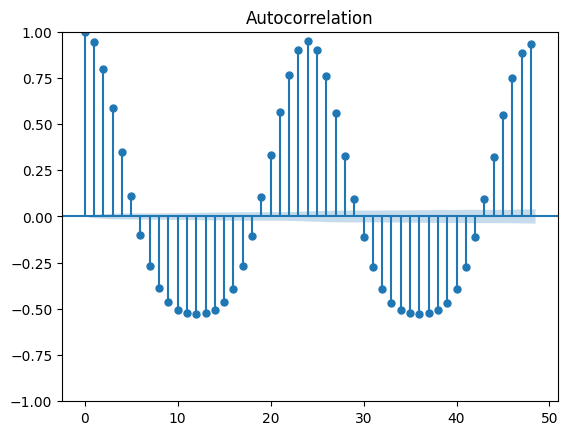

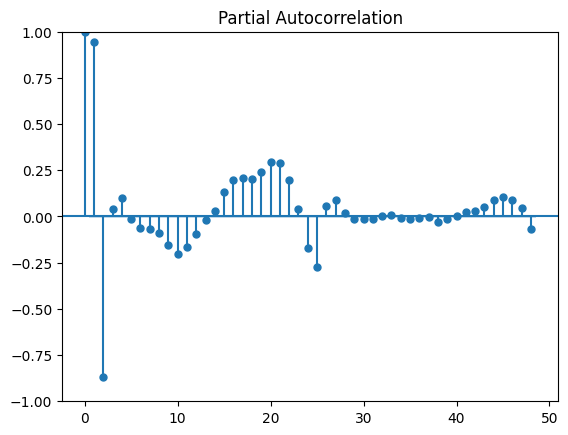

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(df['SolarRadiation'].dropna(), lags=48)
plot_pacf(df['SolarRadiation'].dropna(), lags=48)
plt.show()

## **Modelling Hourly Forecasting**

In [6]:
# ==========================================
# 🌤 Benchmark: XGBoost, RandomForest, LSTM, CNN-LSTM, Simple Transformer
# For daylight-only SolarRadiation (SolarZenith < 90)
# Colab-safe with auto split adjustment
# ==========================================

import os, gc, warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, backend as K

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# ---------- Helper ----------
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

# ---------- 1. Load data ----------
df = pd.read_csv('lahore_hourly_filled.csv', parse_dates=['datetime'], index_col='datetime')
df = df.sort_index().apply(pd.to_numeric, errors='coerce')

# daylight-only filter
df_day = df[df['SolarZenith'] < 90].copy()
df_day.dropna(subset=['SolarRadiation'], inplace=True)
df_day['hour'] = df_day.index.hour
df_day['month'] = df_day.index.month

target_col = 'SolarRadiation'
print(f"✅ Daylight records: {len(df_day)}")

# ---------- 2. Train/Test split ----------
train = df_day.loc[:'2025-06']
test  = df_day.loc['2025-07':]

if len(test) == 0:
    print("⚠️ No daylight test samples found after 2025-07. Shifting split earlier (2025-05/06).")
    train = df_day.loc[:'2025-05']
    test  = df_day.loc['2025-06':]

print(f"Train rows: {len(train)}, Test rows: {len(test)}")

# ---------- 3. Lag features for tree-based models ----------
MAX_LAG = 24
def make_lag_features(series_df, max_lag=24):
    df_feat = series_df[[target_col,'hour','month','Temperature','HumiditySpecific',
                         'HumidityRelative','Pressure','WindSpeed','WindDirection']].copy()
    for lag in range(1, max_lag+1):
        df_feat[f"lag_{lag}"] = df_feat[target_col].shift(lag)
    return df_feat.dropna()

df_lag = make_lag_features(df_day, MAX_LAG)

train_lag = df_lag.loc[train.index.intersection(df_lag.index)]
test_lag  = df_lag.loc[test.index.intersection(df_lag.index)]

if len(test_lag) == 0:
    print("⚠️ Adjusting lag split to ensure test coverage.")
    train_lag = df_lag.iloc[:-MAX_LAG]
    test_lag  = df_lag.iloc[-MAX_LAG:]

X_train_tree = train_lag.drop(columns=[target_col])
y_train_tree = train_lag[target_col]
X_test_tree  = test_lag.drop(columns=[target_col])
y_test       = test_lag[target_col]

print(f"Tree-model samples: train={len(X_train_tree)}, test={len(X_test_tree)}")

# ---------- 4. Prepare scaled sequence data for deep models ----------
SEQ_LEN = 24
features = ['hour','month','Temperature','HumiditySpecific','HumidityRelative',
            'Pressure','WindSpeed','WindDirection', target_col]
df_seq = df_day[features].dropna()

scaler_X = StandardScaler()
scaler_y = StandardScaler()
train_seq_df = df_seq.loc[:train.index.max()]
scaler_X.fit(train_seq_df.drop(columns=[target_col]))
scaler_y.fit(train_seq_df[[target_col]])

def create_sequences(df_in, seq_len=24):
    Xs, ys, idxs = [], [], []
    arr_X = scaler_X.transform(df_in.drop(columns=[target_col]))
    arr_y = scaler_y.transform(df_in[[target_col]]).flatten()
    for i in range(seq_len, len(df_in)):
        Xs.append(arr_X[i-seq_len:i])
        ys.append(arr_y[i])
        idxs.append(df_in.index[i])
    return np.array(Xs), np.array(ys), np.array(idxs)

X_seq_all, y_seq_all, idxs_all = create_sequences(df_seq, SEQ_LEN)

train_idx_set = set(train.index)
test_idx_set  = set(test.index)
train_mask = np.array([idx in train_idx_set for idx in idxs_all])
test_mask  = np.array([idx in test_idx_set  for idx in idxs_all])

X_train_seq = X_seq_all[train_mask]
y_train_seq = y_seq_all[train_mask]
X_test_seq  = X_seq_all[test_mask]
y_test_seq  = y_seq_all[test_mask]

if len(X_test_seq) == 0:
    print("⚠️ No test sequences found, shifting split earlier.")
    train = df_day.loc[:'2025-05']
    test  = df_day.loc['2025-06':]
    train_idx_set = set(train.index)
    test_idx_set  = set(test.index)
    train_mask = np.array([idx in train_idx_set for idx in idxs_all])
    test_mask  = np.array([idx in test_idx_set  for idx in idxs_all])
    X_train_seq = X_seq_all[train_mask]
    y_train_seq = y_seq_all[train_mask]
    X_test_seq  = X_seq_all[test_mask]
    y_test_seq  = y_seq_all[test_mask]

if len(X_test_seq) == 0:
    raise ValueError("No daylight test data found even after split adjustment.")

y_train_unscaled = scaler_y.inverse_transform(y_train_seq.reshape(-1,1)).flatten()
y_test_unscaled  = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

print(f"✅ Sequence data: train={len(X_train_seq)}, test={len(X_test_seq)}")

# ---------- 5. Results container ----------
results = []

# ---------- 6. XGBoost ----------
print("\n=== Training XGBoost ===")
xgb_model = xgb.XGBRegressor(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=RANDOM_STATE, n_jobs=2, verbosity=0
)
xgb_model.fit(X_train_tree, y_train_tree)
xgb_train_pred = xgb_model.predict(X_train_tree)
xgb_test_pred  = xgb_model.predict(X_test_tree)
results.append(['XGBoost',
                r2_score(y_train_tree, xgb_train_pred),
                r2_score(y_test, xgb_test_pred),
                mean_absolute_error(y_test, xgb_test_pred),
                rmse(y_test, xgb_test_pred)])
print("✅ XGBoost done.")
gc.collect()

# ---------- 7. Random Forest ----------
print("\n=== Training Random Forest ===")
rf = RandomForestRegressor(
    n_estimators=200, max_depth=10,
    random_state=RANDOM_STATE, n_jobs=2
)
rf.fit(X_train_tree, y_train_tree)
rf_train_pred = rf.predict(X_train_tree)
rf_test_pred  = rf.predict(X_test_tree)
results.append(['Random Forest',
                r2_score(y_train_tree, rf_train_pred),
                r2_score(y_test, rf_test_pred),
                mean_absolute_error(y_test, rf_test_pred),
                rmse(y_test, rf_test_pred)])
print("✅ Random Forest done.")
gc.collect()

# ---------- 8. Helper for Keras training ----------
def compile_and_fit(model, X_tr, y_tr, X_val, y_val, epochs=35, batch_size=64):
    es = callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                 restore_best_weights=True, verbose=0)
    model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
              epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])

# Split validation from training
val_split = 0.08
val_n = max(1, int(len(X_train_seq)*val_split))
X_val_seq = X_train_seq[-val_n:]
y_val_seq = y_train_seq[-val_n:]
X_train_seq_eff = X_train_seq[:-val_n]
y_train_seq_eff = y_train_seq[:-val_n]

n_features = X_train_seq.shape[2]

# ---------- 9. LSTM ----------
print("\n=== Training LSTM ===")
K.clear_session()
lstm_model = models.Sequential([
    layers.Input(shape=(SEQ_LEN, n_features)),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
compile_and_fit(lstm_model, X_train_seq_eff, y_train_seq_eff, X_val_seq, y_val_seq)
lstm_train_pred = scaler_y.inverse_transform(lstm_model.predict(X_train_seq)).flatten()
lstm_test_pred  = scaler_y.inverse_transform(lstm_model.predict(X_test_seq)).flatten()
results.append(['LSTM',
                r2_score(y_train_unscaled, lstm_train_pred),
                r2_score(y_test_unscaled, lstm_test_pred),
                mean_absolute_error(y_test_unscaled, lstm_test_pred),
                rmse(y_test_unscaled, lstm_test_pred)])
print("✅ LSTM done.")
K.clear_session(); gc.collect()

# ---------- 10. CNN-LSTM ----------
print("\n=== Training CNN-LSTM ===")
K.clear_session()
cnn_in = layers.Input(shape=(SEQ_LEN, n_features))
x = layers.Conv1D(32, 3, activation='relu', padding='same')(cnn_in)
x = layers.MaxPool1D(pool_size=2)(x)
x = layers.LSTM(48)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(24, activation='relu')(x)
out = layers.Dense(1)(x)
cnn_lstm_model = models.Model(cnn_in, out)
cnn_lstm_model.compile(optimizer='adam', loss='mse')
compile_and_fit(cnn_lstm_model, X_train_seq_eff, y_train_seq_eff, X_val_seq, y_val_seq)
cnn_train_pred = scaler_y.inverse_transform(cnn_lstm_model.predict(X_train_seq)).flatten()
cnn_test_pred  = scaler_y.inverse_transform(cnn_lstm_model.predict(X_test_seq)).flatten()
results.append(['CNN-LSTM',
                r2_score(y_train_unscaled, cnn_train_pred),
                r2_score(y_test_unscaled, cnn_test_pred),
                mean_absolute_error(y_test_unscaled, cnn_test_pred),
                rmse(y_test_unscaled, cnn_test_pred)])
print("✅ CNN-LSTM done.")
K.clear_session(); gc.collect()

# ---------- 11. Simple Transformer ----------
print("\n=== Training Simple Transformer ===")
K.clear_session()
inp = layers.Input(shape=(SEQ_LEN, n_features))
x = layers.Dense(64, activation='relu')(inp)
attn = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
x = layers.Add()([x, attn])
x = layers.LayerNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1)(x)
transformer_model = models.Model(inp, out)
transformer_model.compile(optimizer='adam', loss='mse')
compile_and_fit(transformer_model, X_train_seq_eff, y_train_seq_eff, X_val_seq, y_val_seq)
trans_train_pred = scaler_y.inverse_transform(transformer_model.predict(X_train_seq)).flatten()
trans_test_pred  = scaler_y.inverse_transform(transformer_model.predict(X_test_seq)).flatten()
results.append(['Simple Transformer',
                r2_score(y_train_unscaled, trans_train_pred),
                r2_score(y_test_unscaled, trans_test_pred),
                mean_absolute_error(y_test_unscaled, trans_test_pred),
                rmse(y_test_unscaled, trans_test_pred)])
print("✅ Transformer done.")
K.clear_session(); gc.collect()

# ---------- 12. Results ----------
results_df = pd.DataFrame(results, columns=['Model','R2_Train','R2_Test','MAE_Test','RMSE_Test'])
order = ['XGBoost','LSTM','Simple Transformer','Random Forest','CNN-LSTM']
results_df['Model'] = pd.Categorical(results_df['Model'], categories=order, ordered=True)
results_df = results_df.sort_values('Model').reset_index(drop=True)

print("\n===== FINAL RESULTS =====")
print(results_df.to_string(index=False))

results_df.to_csv('model_comparison_results.csv', index=False)
print("\n✅ Saved to model_comparison_results.csv")


✅ Daylight records: 35356
Train rows: 33804, Test rows: 1552
Tree-model samples: train=33780, test=1552
✅ Sequence data: train=33780, test=1552

=== Training XGBoost ===
✅ XGBoost done.

=== Training Random Forest ===
✅ Random Forest done.

=== Training LSTM ===
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ LSTM done.

=== Training CNN-LSTM ===
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ CNN-LSTM done.

=== Training Simple Transformer ===
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Transformer done.

===== FINAL RESULTS =====
             Model  R2_Train  R2_Test   MAE_Test  RMSE_Test
           XGBoost  0.985719 0.985470  17.739346  30.233700
              LSTM  0.898945 0.810544  77.032355 109.171611
Simple Transformer  0.689155 0.438128 137.340235 188.007298
     Random Forest  0.989026 0.983858  18.110510  31.866609
          CNN-LSTM  0.904060 0.851743  67.999682  

**Next 7 Day Forecast Beyond Data**

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb

# ---------- 1. Load data ----------
df = pd.read_csv('lahore_hourly_filled.csv', parse_dates=['datetime'], index_col='datetime')
df = df.sort_index().apply(pd.to_numeric, errors='coerce')

# daylight-only filter (for training)
df_day = df[df['SolarZenith'] < 90].copy()
df_day.dropna(subset=['SolarRadiation'], inplace=True)
df_day['hour'] = df_day.index.hour
df_day['month'] = df_day.index.month

target_col = 'SolarRadiation'

# ---------- 2. Lag features ----------
MAX_LAG = 24
def make_lag_features(series_df, max_lag=24):
    df_feat = series_df[[target_col,'hour','month','Temperature','HumiditySpecific',
                         'HumidityRelative','Pressure','WindSpeed','WindDirection']].copy()
    for lag in range(1, max_lag+1):
        df_feat[f"lag_{lag}"] = df_feat[target_col].shift(lag)
    return df_feat.dropna()

df_lag = make_lag_features(df_day, MAX_LAG)
X_train = df_lag.drop(columns=[target_col])
y_train = df_lag[target_col]

# ---------- 3. Train XGBoost ----------
xgb_model = xgb.XGBRegressor(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=2, verbosity=0
)
xgb_model.fit(X_train, y_train)
print("✅ XGBoost trained.")

# ---------- 4. Forecast next 7 days (daylight hours only, 12h/day) ----------
last_time = df_day.index.max()
forecast_days = 7
daylight_hours = range(6, 18)  # 6 AM to 5 PM (12 hours)
forecast_results = []

forecast_input = df_day.iloc[-MAX_LAG:].copy()
expected_columns = forecast_input.columns.tolist()

for day in range(forecast_days):
    for hr in daylight_hours:
        # Create feature row
        row_data = {
            'hour': hr,
            'month': (last_time + pd.Timedelta(days=day)).month,
            'Temperature': forecast_input['Temperature'].iloc[-1],
            'HumiditySpecific': forecast_input['HumiditySpecific'].iloc[-1],
            'HumidityRelative': forecast_input['HumidityRelative'].iloc[-1],
            'Pressure': forecast_input['Pressure'].iloc[-1],
            'WindSpeed': forecast_input['WindSpeed'].iloc[-1],
            'WindDirection': forecast_input['WindDirection'].iloc[-1],
        }
        for lag in range(1, MAX_LAG+1):
            row_data[f'lag_{lag}'] = forecast_input['SolarRadiation'].iloc[-lag]

        X_pred = pd.DataFrame([row_data])
        X_pred = X_pred.reindex(columns=X_train.columns, fill_value=np.nan)
        y_pred = xgb_model.predict(X_pred)[0]
        forecast_results.append({
            'datetime': last_time + pd.Timedelta(days=day, hours=hr),
            'SolarRadiation_Forecast': y_pred
        })

        # Append prediction to forecast_input for next lag calculation
        new_row = {col: np.nan for col in expected_columns}
        new_row['SolarRadiation'] = y_pred
        new_row['hour'] = hr
        new_row['month'] = row_data['month']
        new_row['Temperature'] = row_data['Temperature']
        new_row['HumiditySpecific'] = row_data['HumiditySpecific']
        new_row['HumidityRelative'] = row_data['HumidityRelative']
        new_row['Pressure'] = row_data['Pressure']
        new_row['WindSpeed'] = row_data['WindSpeed']
        new_row['WindDirection'] = row_data['WindDirection']
        new_row_df = pd.DataFrame([new_row], index=[last_time + pd.Timedelta(days=day, hours=hr)])
        forecast_input = pd.concat([forecast_input, new_row_df])

# ---------- 5. Save forecast ----------
forecast_df = pd.DataFrame(forecast_results)
forecast_df.set_index('datetime', inplace=True)
forecast_df.to_csv('xgboost_7day_daylight_forecast.csv')
print("✅ 7-day daylight-only forecast saved to xgboost_7day_daylight_forecast.csv")
print(forecast_df.head(24))  # first 12-hour daylight of day 1


✅ XGBoost trained.
✅ 7-day daylight-only forecast saved to xgboost_7day_daylight_forecast.csv
                     SolarRadiation_Forecast
datetime                                    
2025-10-22 23:00:00                37.059315
2025-10-23 00:00:00               199.914749
2025-10-23 01:00:00               391.624847
2025-10-23 02:00:00               568.055664
2025-10-23 03:00:00               677.752686
2025-10-23 04:00:00               696.070190
2025-10-23 05:00:00               671.796875
2025-10-23 06:00:00               594.722168
2025-10-23 07:00:00               460.763702
2025-10-23 08:00:00               283.236847
2025-10-23 09:00:00               117.083389
2025-10-23 10:00:00                12.396963
2025-10-23 23:00:00                44.576225
2025-10-24 00:00:00               197.593567
2025-10-24 01:00:00               380.266602
2025-10-24 02:00:00               541.592407
2025-10-24 03:00:00               653.201416
2025-10-24 04:00:00               675.377319
2025-1